In [1]:
import sys
import os
from os.path import join
import time
import torch
import cupy as cp
from cuml.decomposition import PCA, TruncatedSVD
from sklearn.decomposition import PCA as PCA_sklearn
# Suppose your tensor is already on the GPU
# x = torch.randn(1110, 256, 56, 56, device='cpu')
# x = feat_dict_lyrswp['.layer1.Bottleneck0'] # shape: [1110, 256, 56, 56]
# torch.save(x, join(dataroot, "temp_data_layer1_bottleneck0.pt"))
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
x = torch.load(join(dataroot, "temp_data_layer1_bottleneck0.pt"))

In [2]:
# Flatten the tensor from dim 1 onward
x_flat = x.view(x.size(0), -1)  # shape: (1110, 802816)
n_components = 1000

In [3]:
# Option 1: Using DLPack to convert to CuPy array (efficient, avoids extra copies)
# x_cupy = cp.fromDlpack(torch.utils.dlpack.to_dlpack(x_flat))
# Option 2: Alternatively, if you don't use DLPack (this moves data to CPU then to GPU memory)
t0 = time.time()
x_cupy = cp.asarray(x_flat.cpu().numpy())
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")
# Define the number of principal components you want
# Initialize cuML's PCA
pca = PCA(n_components = n_components)
# Fit and transform the data using PCA
x_pca = pca.fit_transform(x_cupy)
print("Transformed shape:", x_pca.shape)  # Should be (1110, n_components)
t2 = time.time()
print(f"Time taken: {t2 - t1} seconds")

Time taken: 1.6050195693969727 seconds


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /n/home12/binxuwang/.conda/envs/torch2/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [6]:
# Option 1: Using DLPack to convert to CuPy array (efficient, avoids extra copies)
# x_cupy = cp.fromDlpack(torch.utils.dlpack.to_dlpack(x_flat))
# Option 2: Alternatively, if you don't use DLPack (this moves data to CPU then to GPU memory)
t0 = time.time()
x_cupy = cp.asarray(x_flat.cpu().numpy())
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")
# Define the number of principal components you want
# Initialize cuML's PCA
pca = PCA(n_components = n_components, svd_solver='jacobi')
# Fit and transform the data using PCA
x_pca = pca.fit_transform(x_cupy,)
print("Transformed shape:", x_pca.shape)  # Should be (1110, n_components)
t2 = time.time()
print(f"Time taken: {t2 - t1} seconds")

Time taken: 0.3794596195220947 seconds


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /n/home12/binxuwang/.conda/envs/torch2/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [4]:
# Option 1: Using DLPack to convert to CuPy array (efficient, avoids extra copies)
# x_cupy = cp.fromDlpack(torch.utils.dlpack.to_dlpack(x_flat))
# Option 2: Alternatively, if you don't use DLPack (this moves data to CPU then to GPU memory)
t0 = time.time()
x_cupy = cp.asarray(x_flat.cpu().numpy())
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")
# Define the number of principal components you want
# Initialize cuML's PCA
pca = PCA(n_components = n_components)
# Fit and transform the data using PCA
x_pca = pca.fit_transform(x_cupy.T)
print("Transformed shape:", x_pca.shape)  # Should be (1110, n_components)
t2 = time.time()
print(f"Time taken: {t2 - t1} seconds")

Time taken: 0.23645663261413574 seconds
Transformed shape: (802816, 1000)
Time taken: 0.47155237197875977 seconds


In [ ]:
t2 = time.time()
pca_sklearn = PCA_sklearn(n_components=n_components, svd_solver='randomized', random_state=42)
x_pca_sklearn = pca_sklearn.fit_transform(x_flat.cpu().numpy().T)
print("Transformed shape:", x_pca_sklearn.shape)  # Should be (1110, n_components)
t3 = time.time()
print(f"Time taken: {t3 - t2} seconds")


* Sklearn PCA transpose matrix 329.28 seconds
* cuml PCA transpose matrix 0.32 seconds
* cuml PCA original matrix -- CUDA Out of Memory

In [ ]:
# cuml TruncatedSVD
t3 = time.time()
svd = TruncatedSVD(n_components=n_components, algorithm='full', random_state=42)
x_svd = svd.fit_transform(x_cupy.T)
t4 = time.time()
print("Transformed shape:", x_svd.shape)  # Should be (1110, n_components)
print(f"Time taken: {t4 - t3} seconds")

In [79]:
import torch

def pca_dual_torch(X, n_components=None, device='cuda'):
    """
    Perform PCA using the dual (Gram matrix) method in PyTorch.

    Parameters
    ----------
    X : torch.Tensor, shape (n, d)
        The input data. Rows are samples, columns are features.
    n_components : int or None
        Number of principal components to keep. If None, uses n_components = n.

    Returns
    -------
    X_proj : torch.Tensor, shape (n, k)
        The data projected onto the top k principal components.
    PC_axes : torch.Tensor, shape (k, d)
        The principal component axes (loadings). Row i is the i-th principal axis.
    explained_variance : torch.Tensor, shape (k,)
        The variance explained by each of the top k principal components.
    explained_variance_ratio : torch.Tensor, shape (k,)
        The fraction of the total variance explained by each of the top k components.

    Notes
    -----
    - This method is most helpful when n << d (many more features than samples).
    - Be mindful of numerical stability if some eigenvalues are very small or zero.
    """

    # X shape: (n, d)
    n, d = X.shape
    # 1) Center the data by subtracting the mean of each feature
    X_mean = X.mean(dim=0, keepdim=True)  # shape (1, d)
    X_centered = X - X_mean               # shape (n, d)
    X_centered = X_centered.to(device)
    # 2) Form the Gram matrix G = X_centered @ X_centered.T, which is (n, n)
    G = X_centered @ X_centered.T       # shape (n, n)
    # 3) Compute the eigen-decomposition of G
    #    torch.linalg.eigh returns eigenvalues in ascending order,
    #    so we'll flip them to descending order.
    eigenvalues, eigenvectors = torch.linalg.eigh(G)        # shapes: (n,), (n,n)
    eigenvalues = torch.flip(eigenvalues, dims=[0])         # descending
    eigenvectors = torch.flip(eigenvectors, dims=[1])       # match ordering
    # 4) If n_components is not set, or is larger than n, clamp it to n
    if (n_components is None) or (n_components > n):
        n_components = n
    # Take the top k eigenvalues/vectors
    lam_top = eigenvalues[:n_components]       # shape (k,)
    V_top = eigenvectors[:, :n_components]     # shape (n, k)
    # 5) Back-project eigenvectors to get principal components in feature space:
    #    PC_axes_i = X_centered.T @ v_i / sqrt(lam_i)
    #    This yields an array of shape (d, k)
    #    where each column is one principal axis (component).
    #    We'll do a safe division by sqrt(lambda) with broadcasting.
    denom = torch.sqrt(lam_top).unsqueeze(0)   # shape (1, k)
    W = (X_centered.T @ V_top) / denom         # shape (d, k)
    # 6) We often store principal axes as (k, d), so transpose W
    PC_axes = W.T                              # shape (k, d)
    # 7) Project the data onto these top components => shape (n, k)
    X_proj = X_centered @ W                    # shape (n, k)
    # 8) Compute explained variance and ratio
    #    - The total variance = sum of all eigenvalues / (n-1).
    #    - The variance explained by component i = lam_top[i] / (n-1).
    #    - The ratio is (lam_top[i] / sum of all lam) after scaling.
    total_var = eigenvalues.sum() / (n - 1)
    explained_variance = lam_top / (n - 1)
    explained_variance_ratio = explained_variance / total_var
    del X_centered, G, eigenvalues, eigenvectors, lam_top, V_top, W
    return X_proj.cpu(), PC_axes.cpu(), explained_variance.cpu(), explained_variance_ratio.cpu(), X_mean.cpu()

In [80]:
t0 = time.time()
X_proj, PC_axes, explained_variance, explained_variance_ratio, X_mean = pca_dual_torch(x_flat, n_components=1000, device='cuda')
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")

Time taken: 2.8930020332336426 seconds


In [ ]:
# check the results are the same with sklearn cuml pca 
t1 = time.time()
tmp_x = x_flat.cpu().numpy()[:, :5000]
pca = PCA(n_components=1000, svd_solver='auto', random_state=42)
x_pca = pca.fit_transform(tmp_x)
t2 = time.time()
print(f"Time taken: {t2 - t1} seconds")


Time taken: 1.906965970993042 seconds


In [82]:
import numpy as np

def compare_pca_results(
    x_pca_sklearn,         # shape (n, k): projection from sklearn's PCA
    components_sklearn,    # shape (k, d): principal axes from sklearn's PCA
    explained_var_sklearn, # shape (k,): explained variance from sklearn's PCA
    
    X_proj_torch,          # shape (n, k): projection from pca_dual_torch
    PC_axes_torch,         # shape (k, d): principal axes from pca_dual_torch
    explained_var_torch,   # shape (k,): explained variance from pca_dual_torch
    
    rtol=1e-5, atol=1e-8
):
    """
    Check consistency between sklearn PCA output and custom torch-based dual-PCA output.

    Parameters
    ----------
    x_pca_sklearn : np.ndarray, shape (n, k)
        Projection of data onto top k PCs from sklearn.
    components_sklearn : np.ndarray, shape (k, d)
        PCA axes (each row is a principal axis) from sklearn.
    explained_var_sklearn : np.ndarray, shape (k,)
        Explained variance per component from sklearn (not the ratio).
    X_proj_torch : np.ndarray, shape (n, k)
        Projection of data from pca_dual_torch.
    PC_axes_torch : np.ndarray, shape (k, d)
        PCA axes from pca_dual_torch (each row is one axis).
    explained_var_torch : np.ndarray, shape (k,)
        Explained variance per component from pca_dual_torch (not the ratio).
    rtol : float
        Relative tolerance for np.allclose checks.
    atol : float
        Absolute tolerance for np.allclose checks.

    Returns
    -------
    None. Prints out whether each portion is matching within tolerance.

    Notes
    -----
    - PCA components are only determined up to a sign flip. We fix that by aligning
      each corresponding pair of components so their dot product is positive.
    - The same sign flip is applied to the corresponding projected scores.
    """

    # Make copies so as not to mutate the originals
    PC_axes = PC_axes_torch.copy()
    X_proj = X_proj_torch.copy()

    # 1) Align signs of the principal axes and projected data
    k = min(components_sklearn.shape[0], PC_axes.shape[0])
    proj_mismatch = []
    axis_mismatch = []
    for i in range(k):
        axis_match = np.allclose(components_sklearn[i], PC_axes[i], rtol=rtol, atol=atol)
        axis_match_neg = np.allclose(components_sklearn[i], - PC_axes[i], rtol=rtol, atol=atol)
        proj_match = np.allclose(x_pca_sklearn[:, i], X_proj[:, i], rtol=rtol, atol=atol)
        proj_match_neg = np.allclose(x_pca_sklearn[:, i], - X_proj[:, i], rtol=rtol, atol=atol)
        if axis_match or axis_match_neg:
            pass
        else:
            # print(f"PC {i} does not match")
            proj_mismatch.append(i)
        if proj_match or proj_match_neg:
            pass
        else:
            # print(f"PC projected data {i} does not match")
            proj_mismatch.append(i)
    # for i in range(k):
    #     dotval = np.dot(components_sklearn[i], PC_axes[i])
    #     if dotval < 0:
    #         # Flip sign of the i-th PC axis in torch's result
    #         PC_axes[i] = -PC_axes[i]
    #         # Also flip sign of the i-th dimension in the projection
    #         X_proj[:, i] = -X_proj[:, i]

    # # 2) Check axes
    # axes_match = np.allclose(components_sklearn[:k], PC_axes[:k], rtol=rtol, atol=atol)
    # print("Principal Axes match (up to sign):", axes_match)

    # # 3) Check projection
    # # Since we only aligned signs for the top k, let's compare them as well
    # proj_match = np.allclose(x_pca_sklearn[:, :k], X_proj[:, :k], rtol=rtol, atol=atol)
    # print("Projected data match (up to sign):", proj_match)

    # 4) Check explained variance
    # We compare only the top k if one is bigger
    var_sk = explained_var_sklearn[:k]
    var_torch = explained_var_torch[:k]
    var_match = np.allclose(var_sk, var_torch, rtol=rtol, atol=atol)
    print("Explained variance match:", var_match)
    print(f"PCs mismatch: {proj_mismatch}")
    print(f"PCs mismatch: {axis_mismatch}")
    print("Differences found above tolerance.")
    return proj_mismatch, axis_mismatch

In [102]:
import numpy as np
from sklearn.decomposition import PCA

def create_sklearn_pca_from_torch(
    PC_axes_torch, 
    var_torch, 
    var_ratio_torch, 
    mean_vector_torch, 
    n_samples
):
    """
    Construct and return a scikit-learn PCA object whose attributes
    are initialized from the results of a torch-based PCA.

    Parameters
    ----------
    PC_axes_torch : torch.Tensor
        Principal component axes of shape (n_features, n_components).
    var_torch : torch.Tensor
        Explained variance of shape (n_components,).
    var_ratio_torch : torch.Tensor
        Explained variance ratio of shape (n_components,).
    mean_vector_torch : torch.Tensor
        Mean vector that was subtracted out, of shape (n_features,).
    n_samples : int
        Number of samples used in the PCA.

    Returns
    -------
    pca : sklearn.decomposition.PCA
        A PCA object that can be used for transform, inverse_transform, etc.
    """

    # Bring everything back to CPU as NumPy arrays
    # Convert tensors to numpy arrays, handling both torch tensors and numpy arrays
    PC_axes = PC_axes_torch.cpu().numpy() if hasattr(PC_axes_torch, 'cpu') else PC_axes_torch        # shape (n_components, n_features)
    var = var_torch.cpu().numpy() if hasattr(var_torch, 'cpu') else var_torch                        # shape (n_components,)
    var_ratio = var_ratio_torch.cpu().numpy() if hasattr(var_ratio_torch, 'cpu') else var_ratio_torch    # shape (n_components,)
    mean_vector = mean_vector_torch.cpu().numpy() if hasattr(mean_vector_torch, 'cpu') else mean_vector_torch # shape (n_features,)

    # Infer shapes
    n_components, n_features = PC_axes.shape
    
    # Instantiate PCA with the correct number of components
    pca = PCA(n_components=n_components)

    # Assign the core PCA attributes
    pca.components_ = PC_axes                     # shape -> (n_components, n_features)
    pca.explained_variance_ = var                   # (n_components,)
    pca.explained_variance_ratio_ = var_ratio       # (n_components,)
    pca.mean_ = mean_vector                         # (n_features,)

    # Compute singular values using the standard relationship:
    # singular_values_ = sqrt(explained_variance_ * (n_samples - 1))
    pca.singular_values_ = np.sqrt(var * (n_samples - 1))

    # Additional attributes required by newer sklearn versions
    pca.n_samples_seen_ = n_samples
    pca.n_features_in_ = n_features
    pca.n_components_ = n_components

    return pca

In [68]:
import matplotlib.pyplot as plt

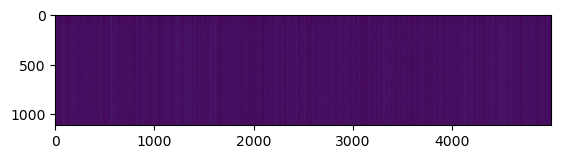

In [72]:
col_idx = np.random.choice(x_flat.shape[1], size=5000, replace=False)
tmp_x = x_flat.cpu().numpy()[:, col_idx]
plt.imshow(tmp_x)
plt.show()


### Check the results match for randn data

In [83]:
# random select columns
# col_idx = np.random.choice(x_flat.shape[1], size=1000, replace=False)
# tmp_x = x_flat.cpu().numpy()[:, col_idx]
tmp_x = np.random.randn(1100, 20000)
# sklearn's PCA
pca = PCA_sklearn(n_components=1000, svd_solver='auto', )
t0 = time.time()
x_pca_sklearn = pca.fit_transform(tmp_x)            # (n, k)
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")
components_sklearn = pca.components_               # (k, d)
explained_var_sklearn = pca.explained_variance_    # (k,)

# sklearn cuml PCA (use CUDA compute)
t0 = time.time()
pca_cuml = PCA(n_components=1000, svd_solver='auto', )
x_pca_cuml = pca_cuml.fit_transform(tmp_x)
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")
components_cuml = pca_cuml.components_
explained_var_cuml = pca_cuml.explained_variance_

# torch dual PCA
t0 = time.time()
X_proj_torch, PC_axes_torch, var_torch, var_ratio_torch, X_mean_torch = pca_dual_torch(
    torch.from_numpy(tmp_x), n_components=1000, device='cuda'
)
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")
X_proj_torch = X_proj_torch.cpu().numpy()          # bring back to CPU if needed
PC_axes_torch = PC_axes_torch.cpu().numpy()
var_torch = var_torch.cpu().numpy()
pca_reconstructed = create_sklearn_pca_from_torch(
    PC_axes_torch, var_torch, var_ratio_torch, X_mean_torch, tmp_x.shape[0]
)
# Compare
compare_pca_results(
    x_pca_sklearn, 
    components_sklearn, 
    explained_var_sklearn,
    X_proj_torch, 
    PC_axes_torch, 
    var_torch,
    rtol=1e-4,
    atol=1e-4
)
compare_pca_results(
    x_pca_cuml, 
    components_cuml, 
    explained_var_cuml,
    X_proj_torch, 
    PC_axes_torch, 
    var_torch,
    rtol=1e-4,
    atol=1e-4
)

Time taken: 16.32219624519348 seconds
Time taken: 16.927454233169556 seconds
Time taken: 0.2155911922454834 seconds
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.


([], [])

In [90]:
tmp_x.shape[0]

1100

In [111]:
X_proj_torch, PC_axes_torch, var_torch, var_ratio_torch, X_mean_torch = pca_dual_torch(
    torch.from_numpy(tmp_x), n_components=1000, device='cuda'
)
pca_reconstructed = create_sklearn_pca_from_torch(
    PC_axes_torch, var_torch, var_ratio_torch, X_mean_torch, tmp_x.shape[0]
)
X_transformed_pca_reconstructed = pca_reconstructed.transform(tmp_x)
assert np.allclose(X_transformed_pca_reconstructed, X_proj_torch)
print("Reconstructed PCA matches the original PCA")

Reconstructed PCA matches the original PCA


: 

In [104]:
pca_reconstructed.components_.shape

(1000, 20000)

Even just with 20000 features 
* sklearn PCA
    * 16.357911109924316 seconds
* sklearn cuml PCA (use CUDA memory)
    * 16.90485119819641 seconds
* dual formulation, torch. 
    * 0.21915674209594727 seconds

In [38]:
torch.cuda.empty_cache()

In [5]:
t0 = time.time()
X_proj, PC_axes, explained_variance, explained_variance_ratio = pca_dual_torch(x_flat, n_components=1000)
t1 = time.time()
print(f"Time taken: {t1 - t0} seconds")

Time taken: 37.77032947540283 seconds


In [10]:
torch.cuda.empty_cache()

### 1100x2000
* PCA Sklearn Time taken: 1.0328459739685059 seconds
* PCA Cuml Time taken: 0.5198838710784912 seconds
* PCA Dual Torch eigen decomposition Time taken: 0.15224599838256836 seconds
* Reconstructed PCA matches the original PCA
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.

### 1100x5000
* PCA Sklearn Time taken: 2.931845188140869 seconds
* PCA Cuml Time taken: 0.4969480037689209 seconds
* PCA Dual Torch eigen decomposition Time taken: 0.054297685623168945 seconds
* Reconstructed PCA matches the original PCA
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.

### 1100x10000
* PCA Sklearn Time taken: 6.9776530265808105 seconds
* PCA Cuml Time taken: 2.681550979614258 seconds
* PCA Dual Torch eigen decomposition Time taken: 0.11720681190490723 seconds
* Reconstructed PCA matches the original PCA
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.

### 1100x20000
* PCA Sklearn Time taken: 16.780861854553223 seconds
* PCA Cuml Time taken: 16.964520692825317 seconds
* PCA Dual Torch eigen decomposition Time taken: 0.2207474708557129 seconds
* Reconstructed PCA matches the original PCA
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.

### 1100x30000
* PCA Sklearn Time taken: 7.8800365924835205 seconds
* PCA Cuml Time taken: 53.59654116630554 seconds
* PCA Dual Torch eigen decomposition Time taken: 0.32802557945251465 seconds
* Reconstructed PCA matches the original PCA
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.
Explained variance match: True
PCs mismatch: []
PCs mismatch: []
Differences found above tolerance.